In [ ]:
# clone glow
!git clone https://github.com/y0ast/Glow-PyTorch.git
%cd Glow-PyTorch/

Cloning into 'Glow-PyTorch'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 77 (delta 36), reused 25 (delta 25), pack-reused 31
Unpacking objects: 100% (77/77), done.
/content/Glow-PyTorch


In [ ]:
# imports
import json
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import get_CIFAR10, get_SVHN, postprocess
from model import Glow
from torchvision import datasets, transforms
from pathlib import Path

# initialize torch with cuda
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  print('Initialize a GPU session')

### Histogram of Data Statistics

In [ ]:
transform = transforms.Compose([
    # you can add other transformations in this list
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_cifar10 = datasets.CIFAR10(
    Path('data_noTransform') / "data" / "CIFAR10",
    train=True,
    transform=transform,
    download=True
    )

test_cifar10 = datasets.CIFAR10(
    Path('data_noTransform') / "data" / "CIFAR10",
    train=False,
    transform=transform,
    download=True
    )

train_cifar100 = datasets.CIFAR100(
    Path('data_noTransform') / "data" / "CIFAR100",
    train=True,
    transform=transform,
    download=True
    )
test_cifar100 = datasets.CIFAR100(
    Path('data_noTransform') / "data" / "CIFAR10",
    train=False,
    transform=transform,
    download=True
    )

train_svhn = datasets.SVHN(
    Path('data_noTransform') / "data" / "SVHN",
    split="train",
    transform=transform,
    download=True
    )

test_svhn = datasets.SVHN(
    Path('data_noTransform') / "data" / "SVHN",
    split="test",
    transform=transform,
    download=True
    )
# Not found in stable release. Issue: https://github.com/pytorch/vision/pull/4109
# train_celeb = datasets.CelebA(
#     Path('data_noTransform') / "data" / "CelebA",
#     split="train",
#     transform=transform,
#     download=True
#     )

# Not publicly accessible error
# train_ImageNet = datasets.ImageNet(
#     Path('data_noTransform') / "data" / "ImageNet",
#     split="train",
#     transform=transform,
#     download=True
#     )


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data_noTransform/data/CIFAR10/cifar-10-python.tar.gz to data_noTransform/data/CIFAR10
Files already downloaded and verified


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data_noTransform/data/CIFAR100/cifar-100-python.tar.gz to data_noTransform/data/CIFAR100


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data_noTransform/data/CIFAR10/cifar-100-python.tar.gz to data_noTransform/data/CIFAR10


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [ ]:
# Reference: https://discuss.pytorch.org/t/about-normalization-using-pre-trained-vgg16-networks/23560

def getDatasetStats(dataLoader=None):
  mean = 0.
  std = 0.
  tot_sample = 0

  for data, _ in dataLoader:
    batch_samples = data.size(0) # batch size (the last batch can have smaller size!)
    tot_sample += batch_samples
    data = data.view(batch_samples, -1)
    mean += data.sum(0)

  mean = mean/tot_sample

  for data, _ in dataLoader:
    batch_samples = data.size(0) # batch size (the last batch can have smaller size!)
    data = data.view(batch_samples, -1)
    data -= mean
    std += (data**2).sum(0) 

  std = std/(tot_sample-1) 

  return mean, std

combined_svhn = torch.utils.data.ConcatDataset([train_svhn, test_svhn])
dataloader = torch.utils.data.DataLoader(combined_svhn, batch_size=512)
# dataloader = torch.utils.data.DataLoader(test_svhn, batch_size=512)
mean_svhn, std_svhn = getDatasetStats(dataloader)

combined_cifar10 = torch.utils.data.ConcatDataset([train_cifar10, test_cifar10])
dataloader = torch.utils.data.DataLoader(combined_cifar10, batch_size=512)
mean_cifar10, std_cifar10 = getDatasetStats(dataloader)

combined_cifar100 = torch.utils.data.ConcatDataset([train_cifar100, test_cifar100])
dataloader = torch.utils.data.DataLoader(combined_cifar100, batch_size=512)
mean_cifar100, std_cifar100 = getDatasetStats(dataloader)



# Distributions

In [ ]:
# Cauchy distribution
from scipy.stats import cauchy
from numpy import linspace
from pylab import plot,show,hist,figure,title
import time
# picking 150 of from a normal distrubution
# with mean 0 and standard deviation 1

#param = norm.fit(samp) # distribution fitting

def getDatasetStats(dataLoader=None):
  complete_loc = []
  complete_scale = []

  complete_data = torch.empty([1,3*32*32])

  for data, _ in dataLoader:
    batch_samples = data.size(0) # batch size (the last batch can have smaller size!)
    complete_data = torch.cat((complete_data, data.view(-1,3*32*32)),0)
  complete_data = complete_data[1:, :]

  for dim in complete_data.swapaxes(1,0):
    times = time.time()
    loc, scale = cauchy.fit(dim)
    complete_loc += [loc]
    complete_scale += [scale]
    #print(time.time() - times)
  return complete_loc, complete_scale

dataloader = torch.utils.data.DataLoader(train_svhn, batch_size=512)
loc_svhn, scale_svhn = getDatasetStats(dataloader)

dataloader = torch.utils.data.DataLoader(train_cifar10, batch_size=512)
loc_cifar10, scale_cifar10 = getDatasetStats(dataloader)

dataloader = torch.utils.data.DataLoader(train_cifar100, batch_size=512)
loc_cifar100, scale_cifar100 = getDatasetStats(dataloader)

df_loc = pd.DataFrame({'SVHN':loc_svhn,
                         'Cifar10':loc_cifar10,
                         'Cifar100':loc_cifar100})
df_scale = pd.DataFrame({'SVHN':scale_svhn,
                       'Cifar10':scale_cifar10,
                       'Cifar100':scale_cifar100})

sns.displot(df_loc, kind='kde')
plt.show()

sns.displot(df_scale, kind='kde')
plt.show()




KeyboardInterrupt: ignored

In [ ]:
# F distribution
from scipy.stats import f
from numpy import linspace
from pylab import plot,show,hist,figure,title
import time
# picking 150 of from a normal distrubution
# with mean 0 and standard deviation 1

#param = norm.fit(samp) # distribution fitting

def getDatasetStats(dataLoader=None):
  complete_dfn = []
  complete_dfd = []

  complete_data = torch.empty([1,3*32*32])

  counter = 0
  for data, _ in dataLoader:
    batch_samples = data.size(0) # batch size (the last batch can have smaller size!)
    counter += batch_samples
    complete_data = torch.cat((complete_data, data.view(-1,3*32*32)),0)
    if (counter >= 20000):
      break
  complete_data = complete_data[1:, :]

  for dim in complete_data.swapaxes(1,0):
    times = time.time()
    dfn, dfd, loc, scale= f.fit(dim)
    complete_dfn += [dfn]
    complete_dfd += [dfd]
    #print(time.time() - times)
  return complete_dfd, complete_dfn

dataloader = torch.utils.data.DataLoader(train_svhn, batch_size=512)
dfd_svhn, dfn_svhn = getDatasetStats(dataloader)

dataloader = torch.utils.data.DataLoader(train_cifar10, batch_size=512)
dfd_cifar10, dfn_cifar10 = getDatasetStats(dataloader)

dataloader = torch.utils.data.DataLoader(train_cifar100, batch_size=512)
dfd_cifar100, dfn_cifar100 = getDatasetStats(dataloader)



/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


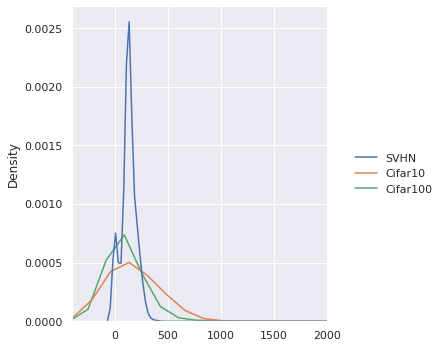

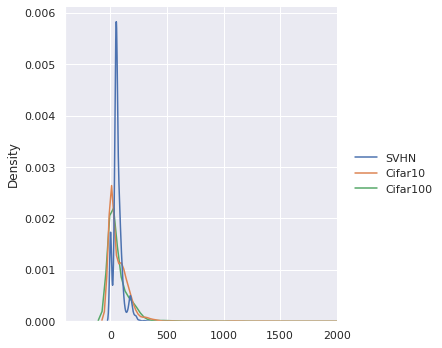

In [ ]:
dfd = pd.DataFrame({'SVHN':dfd_svhn,
                         'Cifar10':dfd_cifar10,
                         'Cifar100':dfd_cifar100})


sns.displot(dfd, kind='kde')
plt.xlim(-400,2000)
plt.show()

dfn = pd.DataFrame({'SVHN':dfn_svhn,
                         'Cifar10':dfn_cifar10,
                         'Cifar100':dfn_cifar100})

sns.displot(dfn, kind='kde')
plt.xlim(-400,2000)
plt.show()